# Tutorial 6: Interpolation Error and Linear Regression

## Exercise 1: Interpolation Error analysis

### Question a: Find the interpolating polynomial

We need to find the polynomial interpolating an unknown function through the following nodes.  

| x | y |
| :---: | :---: |
| -5 | 1 |
| -3  | -0.50818 |
| -1.53426 | 0 |
| 2 | 2.0552 |

Since we only have 4 points, we can use at most a cubic polynomial.  
We solve this problem using Monomial interpolation and the Vandermonde coefficient matrix.

In [1]:
X = [-5; -3; -1.53426; 2];
Y = [-1; -0.50818; 0; 2.0552];

VandMat = [ones(length(X)) X X.^2 X.^3];
Coeff = VandMat \ Y;

p(x) = @. Coeff[1] + Coeff[2]*x + Coeff[3]*x^2 + Coeff[4]*x^3;
display(Coeff)

4-element Vector{Float64}:
 0.724575224106396
 0.5482315550892608
 0.05343266946443507
 0.0025538734821677505

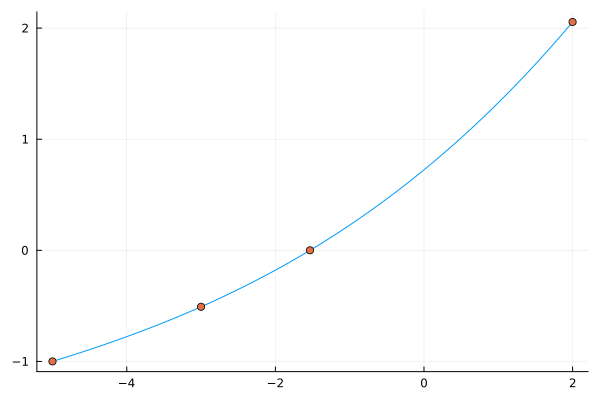

In [2]:
import Plots

x = -5:0.01:2;
Plots.plot(x,p(x),legend=false)
Plots.scatter!(X,Y)

### Question b: Find the interpolation error (numerically)

The interpolated function is written below:
$$f(x) = e^{\frac{1}{5}x+1}-2$$

Since *f* is an exponential function, a polynomial will never be able to correctly approximate it, even with hundreads of points. Therefore, there will always be an interpolation error that does not come from rounding.  

We can estimate numerically this error:

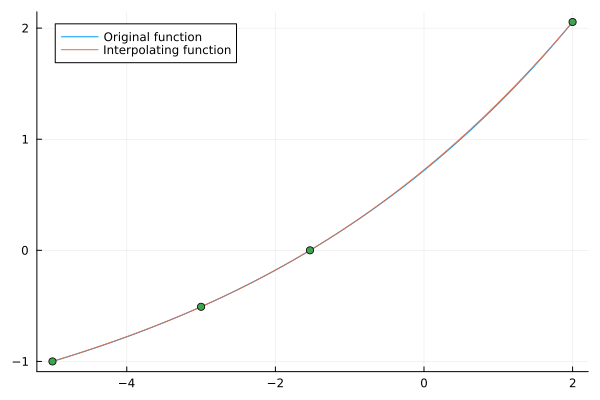

In [3]:
f(x) = @. exp(1/5*x+1)-2;

x = -5:0.01:2;
Plots.plot(x,f(x),label="Original function")
Plots.plot!(x,p(x),label="Interpolating function")
Plots.scatter!(X,Y,label="")

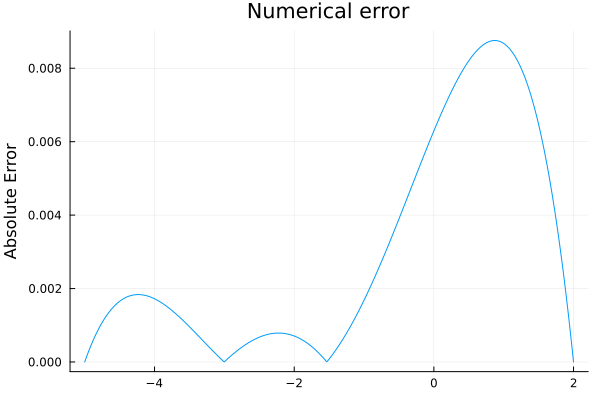

In [4]:
x = -5:0.01:2;
err = abs.(f(x)-p(x));

# Plot the absolute error
Plots.plot(x,err,ylabel="Absolute Error",title="Numerical error",legend=false)

### Question c: Find the interpolation error (analytically)

In our case, we can predict the interpolation error using the following theorem:

$$err(x) = \left|f(x)-p_{3}(x)\right| \leq \frac{M}{4!} \prod_{i=0}^{3} \left|x-x_{i}\right|$$
$$\text{where }M = \max_{x\in[-5,2]}\left|\frac{d^{4}}{{dx}^4}\left(e^{\frac{1}{5}x+1}-2\right)\right|$$

We can compute the value of M as follows:

$$\frac{d^{4}}{{dx}^4}\left(e^{\frac{1}{5}x+1}-2\right) = \frac{1}{5^{4}}e^{\frac{1}{5}x+1}$$
$$M = \max_{x\in[-5,2]}\left|\frac{1}{5^{4}}e^{\frac{1}{5}x+1}\right| = \frac{1}{5^{4}}e^{\frac{7}{5}} \approx 6.49 \cdot 10^{-3}$$  

We can now compute the upper bound of the interpolation error analitically as follows:

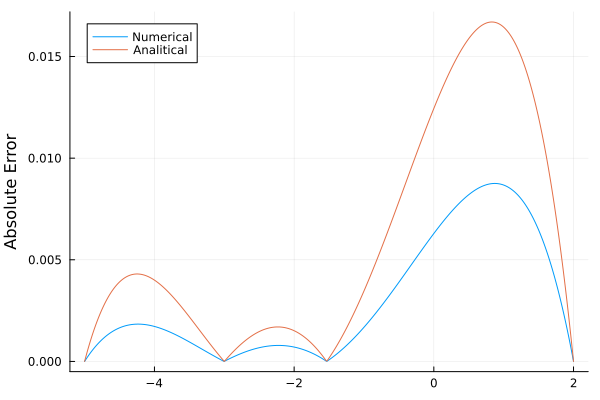

In [5]:
M = 1/5^4*exp(7/5);

errfunc(x) = @. M/factorial(4)*abs(x-X[1])*abs(x-X[2])*abs(x-X[3])*abs(x-X[4]);

# Plot the absolute error (numerical and analytical solution)
Plots.plot(x,err,ylabel="Absolute Error",label="Numerical")
Plots.plot!(x,errfunc(x),label="Analitical")

## Exercise 2: Chebyshev Nodes

Let's compute the 5 Chebyshev nodes for the following function in the range $[-1,1]$:  

$$f(x) = -3\sin\left(\frac{\pi}{2}x\right)+2$$

In our case, the Chebyshev nodes can be found using the following formula:

$$x_{i} = \cos\left(\frac{2i+1}{10}\pi\right),\text{ with }i=0,\dots,4$$

In [6]:
f(x) = @. -3*sin(pi/2*x)+2;

I = 0:4;
X = @. cos((2*I+1)/10*pi);
Y = f(X);

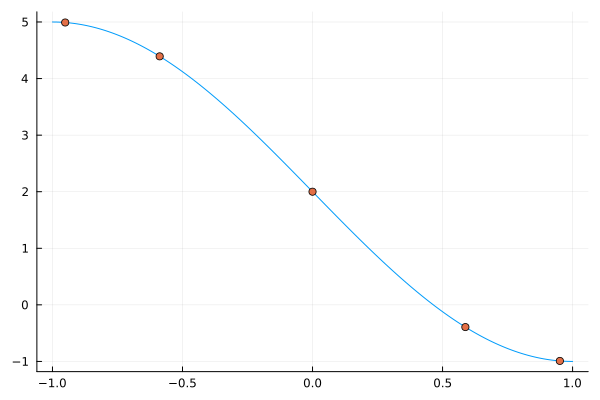

In [7]:
x = -1:0.01:1;
Plots.plot(x,f(x),legend=false)
Plots.scatter!(X,Y)

We can now verify empirically that these interpolation points produce a minimal error by comparing it to randomly chosen interpolation points:

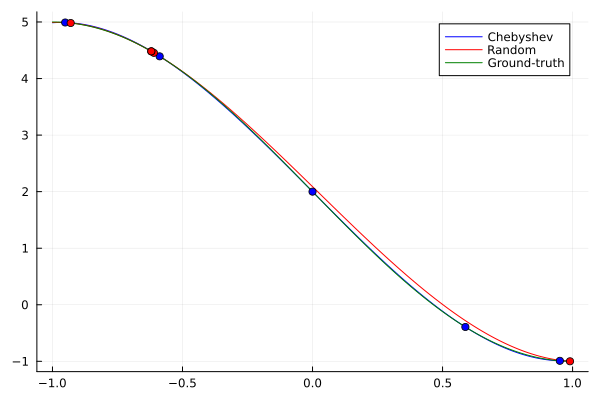

In [8]:
import Random

x = -1:0.01:1;
X1 = Random.rand(x,length(X));
Y1 = f(X1);

# Find interpolation polynomial for Chebyshev nodes (monomial interpolation)
VandMat = [ones(length(X)) X X.^2 X.^3 X.^4];
Coeff = VandMat \ Y;
p(x) = @. Coeff[1] + Coeff[2]*x + Coeff[3]*x^2 + Coeff[4]*x^3 + Coeff[5]*x^4;
    
# Find interpolation polynomial for random nodes (monomial interpolation)
VandMat1 = [ones(length(X1)) X1 X1.^2 X1.^3 X1.^4];
Coeff1 = VandMat1 \ Y1;
p1(x) = @. Coeff1[1] + Coeff1[2]*x + Coeff1[3]*x^2 + Coeff1[4]*x^3 + Coeff1[5]*x^4;
        
# Plot two interpolating polynomials
Plots.plot(x,p(x),label="Chebyshev",color=:blue)
Plots.plot!(x,p1(x),label="Random",color=:red)
Plots.plot!(x,f(x),label="Ground-truth",color=:green)
Plots.scatter!(X,Y,label=false,color=:blue)
Plots.scatter!(X1,Y1,label=false,color=:red)

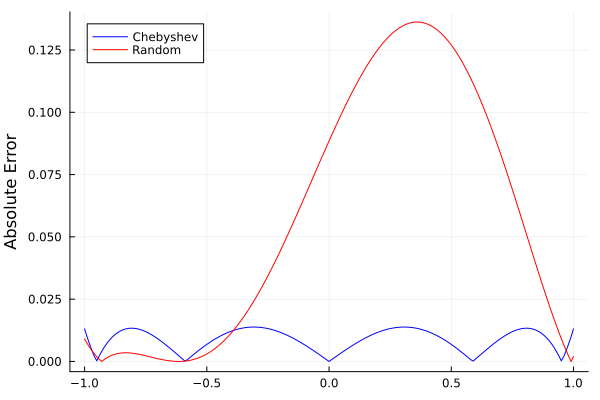

In [9]:
# Compute absolute error for both strategies
err = abs.(p(x)-f(x));
err1 = abs.(p1(x)-f(x));

# Plot absolute error
Plots.plot(x,err,label="Chebyshev",color=:blue,ylabel="Absolute Error")
Plots.plot!(x,err1,label="Random",color=:red)

## Exercise 3: Horner's method

Let's test if Horner's method is more effective computationally for evaluating polynomials than the standard method.

Let's generate a polynomial of 10-th degree with random coefficients:

In [10]:
n = 10;
Coeff = Random.randn(n+1);
x = -2:0.01:2;

function pTrad(c,x)
    p = zeros(size(x));
    
    for i = 1:length(c)
        p = p + c[i]*x .^ (i-1); 
    end
    
    if length(p) == 1
        return p[1]
    else
        return p
    end
end

function pHorn(c,x)
    p = c[end]*ones(size(x));
    
    for i = 1:length(c)-1
        p = c[end-i] .+ x .* p;
    end
    
    if length(p) == 1
        return p[1]
    else
        return p
    end
end;

Let's now evaluate the polynomial defined by the coefficients *Coeff* for 10 times using both methods and compute the average computational method for both strategies.

In [11]:
runs = 100;
timeTrad = zeros(runs);
timeHorn = zeros(runs);

# Run n times the traditional polynomial evaluation
for i = 1:runs
    timeTrad[i] = @elapsed(pTrad(Coeff,x));
    sleep(0.1)
end

# Run n times the Horner's polynomial evaluation
for i = 1:runs
    timeHorn[i] = @elapsed(pHorn(Coeff,x));
    sleep(0.1)
end

In [12]:
function mean(x)
    return sum(x)/length(x)
end

println("Average time for traditional method: ", mean(timeTrad))
println("Average time for Horner's method: ", mean(timeHorn))
        
println("\nHorner's method is ",round(mean(timeTrad)/mean(timeHorn))," times more efficient than the traditional one.")

Average time for traditional method: 0.00092957457
Average time for Horner's method: 0.00057032378

Horner's method is 2.0 times more efficient than the traditional one.


## Exercise 4: Linear Regression

Linear Regression is particularly useful to extrapolate linear relationships from experimental data affected by noise.  
Even if the phenomenon under analysis is extremely linear, the noise and disturbances present when measuring will prevent us from identifying a linear equation using interpolation.
In this cases, it's better to use Regression techniques, such as Least-Square Regression.

Let's generate 50 data points (with random gaussian noise) that show a linear trend. We can approximate the real linear function using Least-Square Regression:

In [13]:
# Define accurate function
n = 50;
f(x) = @. 1.43*x-2.36;

# Choose values of x for which the function is measured
x = 1:0.001:5;
X = Random.rand(x,n);

# Generate measurement affected by noise
Y = f(X) + Random.randn(n)*0.2;

In [14]:
A = [X'*X sum(X); sum(X) n];
b = [X'*Y; sum(Y)];
Coeff = A \ b;

display(Coeff)

2-element Vector{Float64}:
  1.4158625778561194
 -2.3117740978106243

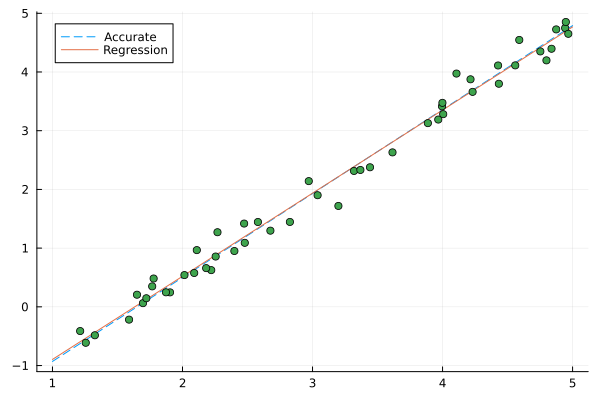

In [15]:
p(x) = @. Coeff[1]*x+Coeff[2];

Plots.plot(x,f(x),linestyle=:dash,label="Accurate")
Plots.plot!(x,p(x),label="Regression")
Plots.scatter!(X,Y,label=false)